# Final Pose Estimation 

okey, so lets's finally perform localization 

In [123]:
import json
import pandas as pd 
import numpy as np 
import torch 
from torch import nn

from utils.pose_utils import invert_se3_np, _q_from_R

In [124]:
path_raw_poses = "./data/sessions_map_ios_query_ios.json"

with open(path_raw_poses) as file:
    dict_raw_poses = json.load(file)

In [125]:
dict_raw_poses.keys()

dict_keys(['path', 'subsession', 'device_id', 'sensor_id', 'timestamp', 'Trs', 'pose_est'])

In [126]:
# df_raw_poses is built from dict_raw_poses
df = pd.DataFrame(dict_raw_poses)
# df.head()

In [127]:
# Normalize the two inputs into arrays
df["Trs"] = df["Trs"].apply(lambda x: np.asarray(x, dtype=np.float32))
df["Tws"] = df["pose_est"].apply(lambda d: np.asarray(d["pose"], dtype=np.float32))

# Compute Twr per row and store as a new column (dtype=object to hold 4x4 arrays)
df["Twr"] = df.apply(lambda r: r["Tws"] @ invert_se3_np(r["Trs"]), axis=1)


In [114]:
dev_id_to_pose_weight = df.groupby(["device_id", "timestamp"]).apply(
    lambda g: (
        g["Twr"].apply(lambda T: torch.tensor(T).to("cuda")).tolist(),
        torch.tensor([1 / (1e-7 + p["error"]) for p in g["pose_est"]]).to("cuda")
    )
).to_dict()

/tmp/ipykernel_987502/365409110.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dev_id_to_pose_weight = df.groupby(["device_id", "timestamp"]).apply(


In [107]:
pose_proposals, weights = dev_id_to_pose_weight[('ios_2023-10-27_10.18.09_000/cam_phone_594319088133', 594319088133)]


In [108]:
import torch
from typing import Literal, Tuple

# -------------------- SO(3)/SE(3) math (Torch, tiny-angle safe) --------------------

def _so3_hat(w: torch.Tensor) -> torch.Tensor:
    """(...,3) -> (...,3,3)"""
    wx, wy, wz = w.unbind(-1)
    O = torch.zeros_like(wx)
    return torch.stack([
        torch.stack([ O, -wz,  wy], dim=-1),
        torch.stack([ wz,  O, -wx], dim=-1),
        torch.stack([-wy, wx,  O], dim=-1)
    ], dim=-2)

def so3_exp(w: torch.Tensor) -> torch.Tensor:
    """(...,3) axis-angle -> (...,3,3) rotation."""
    th = torch.linalg.norm(w, dim=-1, keepdims=True)  # (...,1)
    small = (th.squeeze(-1) < 1e-8)[..., None, None]  # (...,1,1)
    k = torch.where(small, torch.zeros_like(w), w / th)
    K = _so3_hat(k)

    I = torch.eye(3, dtype=w.dtype, device=w.device).expand(*w.shape[:-1], 3, 3)
    sin_th = torch.sin(th)[..., None]
    cos_th = torch.cos(th)[..., None]

    R = I + sin_th * K + (1.0 - cos_th) * (K @ K)
    R = torch.where(small, I, R)
    return R

def so3_log(R: torch.Tensor) -> torch.Tensor:
    """(...,3,3) -> (...,3) axis-angle (tiny-angle safe)."""
    tr = (R[..., 0, 0] + R[..., 1, 1] + R[..., 2, 2]).clamp(-1.0, 3.0)
    cos_th = (tr - 1.0) * 0.5
    th = torch.acos(cos_th.clamp(-1.0, 1.0))                 # (...,)

    w_skew = (R - R.transpose(-1, -2)) * 0.5                  # (...,3,3)
    v = torch.stack([w_skew[..., 2, 1], w_skew[..., 0, 2], w_skew[..., 1, 0]], dim=-1)  # (...,3)

    small = (th < 1e-8)[..., None]  # (...,1)
    s = torch.sin(th).clamp(min=1e-12)[..., None]             # (...,1)
    # general: w = th/(2 sin th) * vee(R - R^T)
    w = (th[..., None] / (2.0 * s)) * v                       # (...,3)

    # ensure exact shape (...,3) in both branches
    w = torch.where(small, v, w)
    return w


def se3_exp(xi: torch.Tensor) -> torch.Tensor:
    """(…,6) -> (…,4,4). xi = [v(3), w(3)]"""
    v, w = xi[..., :3], xi[..., 3:]
    th = torch.linalg.norm(w, dim=-1, keepdims=True)  # (...,1)
    R = so3_exp(w)  # (...,3,3)

    I = torch.eye(3, dtype=xi.dtype, device=xi.device).expand(*xi.shape[:-1], 3, 3)
    small = (th.squeeze(-1) < 1e-8)[..., None, None]
    k = torch.where(small, torch.zeros_like(w), w / th)
    K = _so3_hat(k)
    sin_th = torch.sin(th)[..., None]
    cos_th = torch.cos(th)[..., None]

    # V = I + (1 - cos)K + (th - sin)K^2
    V = I + (1.0 - cos_th) * K + (th - sin_th) * (K @ K)
    # small-angle Taylor: V ≈ I + 0.5K + 1/6 K^2
    V_small = I + 0.5 * K + (1.0/6.0) * (K @ K)
    V = torch.where(small, V_small, V)

    t = (V @ v[..., None]).squeeze(-1)  # (...,3)

    T = torch.eye(4, dtype=xi.dtype, device=xi.device).expand(*xi.shape[:-1], 4, 4).clone()
    T[..., :3, :3] = R
    T[..., :3,  3] = t
    return T

def se3_log(T: torch.Tensor) -> torch.Tensor:
    """(…,4,4) -> (…,6). xi = [v,w]."""
    R = T[..., :3, :3]
    t = T[..., :3,  3]
    w = so3_log(R)                                             # (...,3)
    th = torch.linalg.norm(w, dim=-1, keepdims=True)           # (...,1)

    I = torch.eye(3, dtype=T.dtype, device=T.device).expand(*w.shape[:-1], 3, 3)
    small = (th.squeeze(-1) < 1e-8)[..., None, None]           # (...,1,1)

    # unit axis for K
    k = torch.where((th > 0)[..., None], w / th.clamp(min=1e-12), torch.zeros_like(w))
    K = _so3_hat(k)                                            # (...,3,3)

    sin_th = torch.sin(th)[..., None]
    cos_th = torch.cos(th)[..., None]

    V = I + (1.0 - cos_th) * K + (th - sin_th) * (K @ K)
    V_small = I + 0.5 * K + (1.0/6.0) * (K @ K)
    V = torch.where(small, V_small, V)                         # (...,3,3)

    v = torch.linalg.solve(V, t[..., None]).squeeze(-1)        # (...,3)

    # --- enforce identical leading dims before cat ---
    if w.dim() < v.dim():
        # e.g., v is (1,3) and w is (3,)
        w = w.unsqueeze(0)
    # If shapes still differ due to broadcasting, expand w to v's shape
    if w.shape[:-1] != v.shape[:-1]:
        w = w.expand(*v.shape[:-1], 3)

    return torch.cat([v, w], dim=-1)                           # (...,6)
                   # (...,6)

def se3_inv(T: torch.Tensor) -> torch.Tensor:
    """(…,4,4) -> (…,4,4)"""
    R = T[..., :3, :3]
    t = T[..., :3,  3]
    RT = R.transpose(-1, -2)
    Tin = torch.eye(4, dtype=T.dtype, device=T.device).expand(*T.shape[:-2], 4, 4).clone()
    Tin[..., :3, :3] = RT
    Tin[..., :3,  3] = -(RT @ t[..., None]).squeeze(-1)
    return Tin

# -------------------- Robust M-estimator weights --------------------

def m_weight(r: torch.Tensor,
             kind: Literal["cauchy", "huber"] = "cauchy",
             c: float = 2.0) -> torch.Tensor:
    """
    Return the scalar weight ψ(r)/r for IRLS (influence function over residual norm).
    r: (...,) non-negative residual norms
    """
    eps = 1e-12
    if kind == "cauchy":
        # rho = (c^2/2) * log(1 + (r/c)^2)  ->  w = 1 / (1 + (r/c)^2)
        return 1.0 / (1.0 + (r / (c + eps))**2 + eps)
    elif kind == "huber":
        # rho = 0.5 r^2       if r<=c
        #      = c(r - 0.5c)  if r>c
        w = torch.ones_like(r)
        mask = (r > c)
        w[mask] = (c / (r[mask] + eps))
        return w
    else:
        raise ValueError("Unknown robust kind")

# -------------------- Robust SE(3) averaging --------------------

@torch.no_grad()
def robust_se3_average(
    T_list: torch.Tensor,            # (N,4,4) proposals
    w_conf: torch.Tensor,            # (N,)   confidence weights >=0
    Sigma: torch.Tensor | None = None,   # (6,6) covariance (for whitening). If None => I
    *,
    max_iters: int = 20,
    kind: Literal["cauchy", "huber"] = "cauchy",
    c: float = 2.0,
    init: torch.Tensor | None = None,    # (4,4) initial pose. If None, pick best-weighted medoid-ish init
    tol: float = 1e-8,
    device: str | torch.device = "cpu",
    dtype: torch.dtype = torch.float64,
) -> Tuple[torch.Tensor, dict]:
    """
    Returns:
      T*: (4,4) robust mean,
      info: dict with 'iters', 'final_residual', 'num_used'
    """
    T_list = T_list.to(device=device, dtype=dtype)
    w_conf = w_conf.to(device=device, dtype=dtype).clamp(min=0)
    N = T_list.shape[0]
    assert T_list.shape[-2:] == (4,4)
    assert w_conf.shape == (N,)

    # Whitening matrix S = Sigma^{-1/2}
    if Sigma is None:
        S = torch.eye(6, dtype=dtype, device=device)
    else:
        Sigma = Sigma.to(device=device, dtype=dtype)
        # Compute inverse sqrt via Cholesky or eig
        L = torch.linalg.cholesky(Sigma)                # Sigma = L L^T
        S = torch.cholesky_inverse(L)                   # Sigma^{-1}
        # want Sigma^{-1/2}; for robustness we can just use Sigma^{-1/2} via eig:
        w_eig, V = torch.linalg.eigh(Sigma)
        Sinv_sqrt = (V @ torch.diag_embed((1.0 / torch.sqrt(w_eig.clamp(min=1e-12)))) @ V.transpose(-1, -2))
        S = Sinv_sqrt

    # Initialization
    if init is None:
        # simple init: pick pose with max confidence
        T = T_list[w_conf.argmax()]
    else:
        T = init.to(device=device, dtype=dtype)

    info = {}
    for it in range(max_iters):
        # residuals in Lie algebra: xi_i = log(T^{-1} T_i)
        xi = se3_log(se3_inv(T) @ T_list)     # (N,6)

        # whitened norms r_i = || S xi_i ||
        xi_w = (S @ xi.unsqueeze(-1)).squeeze(-1)   # (N,6)
        r = torch.linalg.norm(xi_w, dim=-1)         # (N,)

        # robust IRLS weights
        w_rob = m_weight(r, kind=kind, c=c)        # (N,)
        w = (w_conf * w_rob)                        # (N,)

        # If all weights ~0, stop
        if torch.all(w <= 1e-12):
            break

        # Weighted average in se(3): Δ = sum_i w_i * xi_i / sum_i w_i
        # (You could add anisotropic scaling here; we used S only for robust weights.)
        w_sum = w.sum()
        Delta = (w[:, None] * xi).sum(dim=0) / (w_sum + 1e-12)  # (6,)

        # Update on the manifold
        T_new = se3_exp(Delta) @ T

        # Convergence check (parameter step)
        if torch.linalg.norm(Delta) < tol:
            T = T_new
            break
        T = T_new

    # Final stats
    xi = se3_log(se3_inv(T) @ T_list)
    xi_w = (S @ xi.unsqueeze(-1)).squeeze(-1)
    r = torch.linalg.norm(xi_w, dim=-1)
    w_rob = m_weight(r, kind=kind, c=c)
    w = w_conf * w_rob
    final_loss = (w * r).sum().item()

    info.update(dict(iters=it+1, final_residual=final_loss, num_used=int((w>0).sum().item())))
    return T, info


In [109]:
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float64

# Convert list[Tensor(4,4)] → Tensor(N,4,4)
T_list = torch.stack(
    [t.to(device=dev, dtype=dtype) for t in pose_proposals],
    dim=0
)

# weights should be a 1-D tensor of length N
w_conf = torch.as_tensor(weights, device=dev, dtype=dtype)

# Example anisotropic covariance (optional)
Sigma = torch.diag(torch.tensor([1.0, 1.0, 1.0, 0.5, 0.5, 0.5],
                                device=dev, dtype=dtype))

T_star, info = robust_se3_average(
    T_list, w_conf,
    Sigma=Sigma,
    max_iters=30,
    kind="cauchy", c=2.0,
    init=T_list[w_conf.argmax()],
    device=dev, dtype=dtype,
)

print("Robust mean pose:\n", T_star.cpu().numpy())
print("Details:", info)


Robust mean pose:
 [[[-0.40101892  0.49047747 -0.77370256 -6.84696388]
  [ 0.77102989 -0.27535284 -0.5741896  -8.41227531]
  [-0.49466828 -0.82680869 -0.2677511  -9.29936028]
  [ 0.          0.          0.          1.        ]]]
Details: {'iters': 1, 'final_residual': 0.0, 'num_used': 1}


In [128]:
import csv
import torch
import numpy as np

# --- config ---
dev   = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float64

# Assume you already have: robust_se3_average(T_list, w_conf, ...) defined
# Assume you already have: rot_to_quat(R: np.ndarray[3x3]) -> tuple(qw, qx, qy, qz)

# 1) Build (device_id, timestamp) -> (list_of_Twr, weights) dict (tensors on the right device/dtype)
def _weight_from_pose_est(p):
    # example: inverse of error; tweak as you like
    return 1.0 / (1e-7 + p["error"])

grp_series = (
    df.groupby(["device_id", "timestamp"])
      .apply(lambda g: (
          # list of 4x4 tensors
          [torch.as_tensor(T, device=dev, dtype=dtype) for T in g["Twr"].values],
          # 1D weights tensor
          torch.as_tensor([_weight_from_pose_est(p) for p in g["pose_est"].values],
                          device=dev, dtype=dtype)
      ))
)

dev_id_to_pose_weight = grp_series.to_dict()  # keys: (device_id, timestamp)

# 2) Run robust_se3_average per key
results = []  # rows to write: [timestamp, device_id, qw, qx, qy, qz, tx, ty, tz]

for (device_id, ts), (pose_list, w_conf) in sorted(dev_id_to_pose_weight.items(),
                                                   key=lambda kv: (kv[0][0], kv[0][1])):
    # skip empty
    if not pose_list:
        continue

    # Stack to (N,4,4)
    T_list = torch.stack(pose_list, dim=0)  # (N,4,4)

    # Guard: if weights length mismatches N, fix/truncate
    N = T_list.shape[0]
    if w_conf.numel() != N:
        w_conf = w_conf.flatten()
        N2 = min(N, w_conf.numel())
        T_list = T_list[:N2]
        w_conf = w_conf[:N2]

    # If only one proposal, just take it; else robust average
    if T_list.shape[0] == 1:
        T_star = T_list[0]
    else:
        # (optional) anisotropic covariance between trans/rot, else pass Sigma=None
        Sigma = None
        # init: best weight
        init_T = T_list[torch.argmax(w_conf)]
        T_star, _info = robust_se3_average(
            T_list, w_conf,
            Sigma=Sigma,
            max_iters=30,
            kind="cauchy", c=2.0,
            init=init_T,
            device=dev, dtype=dtype
        )

    # Extract R,t and convert to quaternion
    R = T_star[:3, :3].detach().cpu().numpy()
    t = T_star[:3,  3].detach().cpu().numpy()
    qw, qx, qy, qz = _q_from_R(R)  # your function

    # Append row (covariance left empty for now)
    results.append([str(ts), device_id, f"{qw:.17g}", f"{qx:.17g}", f"{qy:.17g}", f"{qz:.17g}",
                    f"{t[0]:.17g}", f"{t[1]:.17g}", f"{t[2]:.17g}"])

# 3) Write to txt (CSV with commas). No header unless you want one.
out_txt = "HYDRO_map_ios_query_ios.txt"
with open(out_txt, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    # Optionally write a header:
    w.writerow(["timestamp","device_id","qw","qx","qy","qz","tx","ty","tz", "*covar"])
    w.writerows(results)

print(f"Wrote {len(results)} rows to {out_txt}")


Wrote 407 rows to HYDRO_map_ios_query_ios.txt


/tmp/ipykernel_987502/4207708913.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (


# qualitative analysis 

In [18]:
from utils.dataset import IOSMapDataset, SpotMapDataset
from utils.pose_utils import parse_trajectories_txt, _q_to_R, _RT_to_T
import torchvision.transforms as T
import numpy as np 
import matplotlib.pyplot as plt 

In [20]:
root = "/media/jbhayet/Data/datasets/crocodl-dataset/capture/HYDRO/sessions"  # contains ios_map/ and ios_query/
tfm = T.Compose([T.Resize((480, 640)), T.ToTensor()])

map_ds = IOSMapDataset(root, transform=tfm, subsession="ios_2023-10-27_10.20.23_000")
poses_ds = parse_trajectories_txt("submission/HYDRO_map_ios_query_ios.txt")

In [21]:
ref_every = 1
ref_poses = []
for idx in range(len(map_ds)):
    if idx % ref_every == 0:
        item = map_ds[idx]
        dev_id = item["dev_id"]
        ref_poses.append(item["Twc"])
ref_poses = np.stack(ref_poses)
print(len(ref_poses))

q_every = 5
q_poses = []
for idx in range(len(poses_ds)):
    if idx % q_every == 0:
        q_row = poses_ds[idx]
        q_pose = _RT_to_T(R = _q_to_R(q_row.q), t = q_row.t)
        q_poses.append(q_pose)
q_poses = np.stack(q_poses)
print(len(q_poses))

350
82


(350, 3)


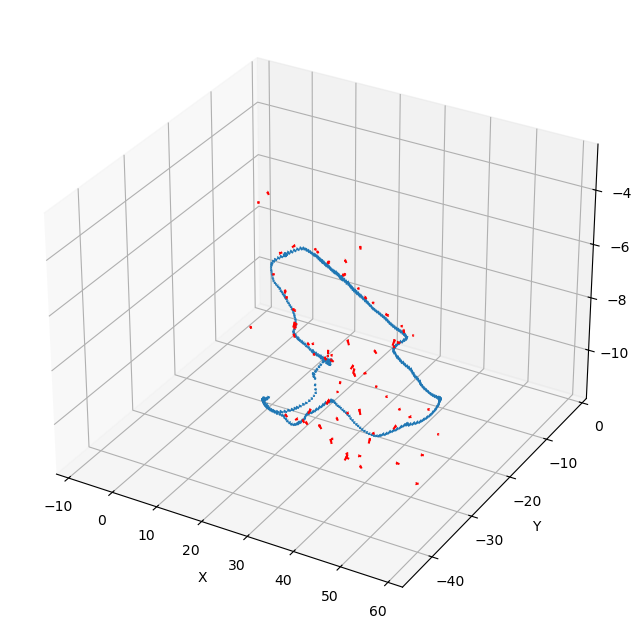

In [22]:
from calendar import c


ref_dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in ref_poses])
ref_origins = ref_poses[:, :3, -1]

q_dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in q_poses])
q_origins = q_poses[:, :3, -1]

print(ref_dirs.shape)
ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_ = ax.quiver(
  ref_origins[..., 0].flatten(),
  ref_origins[..., 1].flatten(),
  ref_origins[..., 2].flatten(),
  ref_dirs[..., 0].flatten(),
  ref_dirs[..., 1].flatten(),
  ref_dirs[..., 2].flatten(), length=0.5, normalize=True)

_ = ax.quiver(
  q_origins[..., 0].flatten(),
  q_origins[..., 1].flatten(),
  q_origins[..., 2].flatten(),
  q_dirs[..., 0].flatten(),
  q_dirs[..., 1].flatten(),
  q_dirs[..., 2].flatten(), length=0.5, normalize=True, color="red")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.show()


In [23]:
root = "/media/jbhayet/Data/datasets/crocodl-dataset/capture/HYDRO/sessions"  
tfm = T.Compose([T.Resize((480, 640)), T.ToTensor()])

map_ds = SpotMapDataset(root, transform=tfm)
poses_ds = parse_trajectories_txt("submission/HYDRO_map_spot_query_hl.txt")

In [24]:
ref_every = 10
ref_poses = []
for idx in range(len(map_ds)):
    if idx % ref_every == 0:
        item = map_ds[idx]
        dev_id = item["dev_id"]
        ref_poses.append(item["Twc"])
ref_poses = np.stack(ref_poses)
print(len(ref_poses))

q_every = 5
q_poses = []
for idx in range(len(poses_ds)):
    if idx % q_every == 0:
        q_row = poses_ds[idx]
        q_pose = _RT_to_T(R = _q_to_R(q_row.q), t = q_row.t)
        q_poses.append(q_pose)
q_poses = np.stack(q_poses)
print(len(q_poses))

491
90


(491, 3)


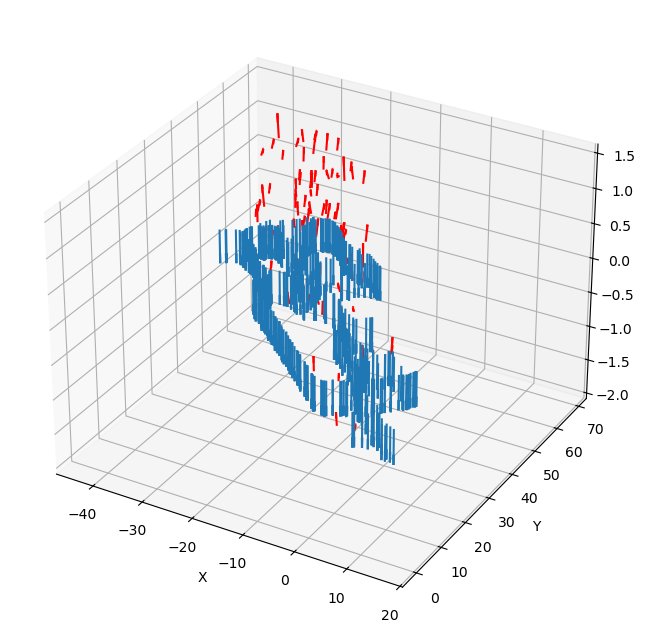

In [25]:
from calendar import c


ref_dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in ref_poses])
ref_origins = ref_poses[:, :3, -1]

q_dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in q_poses])
q_origins = q_poses[:, :3, -1]

print(ref_dirs.shape)
ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_ = ax.quiver(
  ref_origins[..., 0].flatten(),
  ref_origins[..., 1].flatten(),
  ref_origins[..., 2].flatten(),
  ref_dirs[..., 0].flatten(),
  ref_dirs[..., 1].flatten(),
  ref_dirs[..., 2].flatten(), length=0.5, normalize=True)

_ = ax.quiver(
  q_origins[..., 0].flatten(),
  q_origins[..., 1].flatten(),
  q_origins[..., 2].flatten(),
  q_dirs[..., 0].flatten(),
  q_dirs[..., 1].flatten(),
  q_dirs[..., 2].flatten(), length=0.5, normalize=True, color="red")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.show()


In [17]:
ref_origins, q_origins

(array([[ 1.18055358, 19.80370973, -0.11812966],
        [ 1.18053777, 19.80380264, -0.11794059],
        [ 1.18039561, 19.80401379, -0.11821195],
        ...,
        [ 7.93234945, 19.77538309, -0.11410437],
        [ 5.52247875, 21.95552222, -0.10735257],
        [ 3.91508994, 23.69126182, -0.11863015]]),
 array([[ 2.09613554e+07,  9.49047309e+06,  3.45145244e+07],
        [ 1.00614971e+05, -2.99782452e+04,  8.76067754e+04],
        [ 3.50760315e+03, -4.99660258e+03, -4.11430251e+03],
        [ 1.17250861e+07, -1.20445702e+07,  2.04467935e+07],
        [-1.12670601e+06, -6.85572636e+05, -1.92079981e+05],
        [ 1.49356096e+07, -6.20578571e+06,  2.77748213e+07],
        [ 5.52187926e+03,  8.99316241e+03, -6.62052891e+02],
        [ 6.83749823e+04,  2.02184222e+07, -9.69739703e+06],
        [-3.11240645e+06,  5.09155148e+06, -2.43188921e+06],
        [-1.34719415e+07,  3.68430485e+06, -2.33895355e+07],
        [ 1.08068870e+07,  1.03533189e+07,  8.29366168e+06],
        [-1.28115820